In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
from torch import nn

# load Hunter's Potts model package
from potts import Potts

# this is how we load Potts models from CCMpred
from pycameox.optimization import load_ccmpred


# This is a bunch of useful dictionaries
# aa_to_i is the numerical encoding of amino acids
# i_to_aa is the reverse
from pycameox.optimization import (AA_TO_I as aa_to_i, I_TO_AA as i_to_aa,
                                   CODON_TABLE as codon_table)


# this function is used to create a reduced Potts model where certain residues are fixed
# this is done in order to optimize smaller sub-problems
from potts.potts import get_subset_potts_optimized

# toulbar2 is the program that does the ILP optimization
# LG is the file format for toulbar2
from potts.optimize import potts_to_LG_file, run_toulbar2

In [3]:
# Create numerical encoding of codons
bases = [l.upper() for l in 'tcag']
codons = [a + b + c for a in bases for b in bases for c in bases]
# 'XXX' is used to represent a gap 
codon_to_i = {c: i for i, c in enumerate(codons + ['XXX'])}
i_to_codon = {i: c for c, i in codon_to_i.items()}

In [8]:
# REPLACE WITH YOUR PATH 
run_dir = Path(
    '/home/hunter/projects/recombination/structure_potts/cameos/cameos_runs/run_orig_012324'
)
# large and small genes
PROTa = 'aroB_pf5_uref100'
PROTb = 'infA_pf5_uref100'

PROTabP1 = PROTa + '_' + PROTb + '_p1'
PATH = Path(run_dir, 'output', PROTabP1)
metadata = pd.read_csv(PATH / Path('CAMEOX_metadata').with_suffix('.csv'),
                       sep=',',
                       header=0)

#Let's print out what CAMEOX thinks the WT PLLs are so we can compare with our model
wt_protA_psl = -np.mean(metadata['mark_wt_apll'])
print(f'INFO: WT seq APLL for {PROTa} is {wt_protA_psl}')
wt_protB_psl = -np.mean(metadata['deg_wt_apll'])
print(f'INFO: WT seq APLL for {PROTb} is {wt_protB_psl}')


INFO: WT seq APLL for aroB_pf5_uref100 is -230.69763
INFO: WT seq APLL for infA_pf5_uref100 is -56.842094


In [9]:
#Now let's load the CCMpred models
run_dir = Path('/home/hunter/projects/cameos/')
ccmpred_fn_infA = (run_dir / PROTb / Path(PROTb).with_suffix('.raw'))
model_small = load_ccmpred(ccmpred_fn_infA).cpu()

ccmpred_fn_aroB = (run_dir / PROTa / Path(PROTa).with_suffix('.raw'))
model_large = load_ccmpred(ccmpred_fn_aroB).cpu()

In [14]:
aroB_seq = ['MQTLKVDLGERSYPIHIGEGLLDQPELLAPHIAGRQVAIISNETVAPLYLERLNRSLAAYSVISVILPDGEAHKNWETLQLIFDGLLTARHDRRTTVIALGGGVIGDMAGFAAACYQRGVDFIQVPTTLLSQVDSSVGGKTGINHPLGKNMVGAFYQPQAVLIDTATLNTLPPRELSAGLAEVIKYGLICDEPFLTWLEEHVDALRNLDQVALTEAISRSCAAKALVVNADERESGVRATLNLGHTFGHAIETHMGYGVWLHGEAVAAGTVMALDMSQRLGWISAQERDRGIRLFQRAGLPVIPPEEMTEADFLEHMAIDKKVIDGRLRLVLLRHMGEAVVTDDYPKEILQATLGADYRALAQLKG']
# numerically encode aroB
aroB_enc = torch.tensor([[aa_to_i[aa] for aa in s] for s in aroB_seq])
# one-hot-encode encode aroB
aroB_oh = torch.nn.functional.one_hot(aroB_enc, num_classes=21).to(torch.float)
with torch.no_grad():
    # compute pseudo log-likelihood
    aroB_wt_pll = model_large.pseudolikelihood(aroB_oh)
    # compute energy (negative unnormalized log likelihood)
    aroB_energy = model_large(aroB_oh)
aroB_wt_pll.item()

-230.6875

In [18]:
infA_seq = ['MSKEDSFEMEGTVVDTLPNTMFRVELENGHVVTAHISGKMRKNYIRILTGDKVRVELTPYDLSKGRITYRAR']
# numerically encode infA
infA_enc = torch.tensor([[aa_to_i[aa] for aa in s] for s in infA_seq])
# one-hot-encode encode infA
infA_oh = torch.nn.functional.one_hot(infA_enc, num_classes=21).to(torch.float)
with torch.no_grad():
    # compute pseudo log-likelihood
    infA_wt_pll = model_small.pseudolikelihood(infA_oh)
    # compute energy (negative unnormalized log likelihood)
    infA_energy = model_small(infA_oh)
infA_wt_pll.item()

-56.77409744262695

There is some numerical difference between our calculated pLLs and the CAMEOX reported ones. 

However, below we can compare a scatter plot of our calculated pLLs and CAMEOX across many sequences
and see that this just appears to be small numerical precision issues. 

In [34]:
# read in CAMEOX results
df = pd.read_csv('/home/hunter/projects/recombination/structure_potts/cameos/cameos_runs/run_orig_012324/output/aroB_pf5_uref100_infA_pf5_uref100_p1/summary_5IDEtgbS.csv')
aroB_pll_cameox = df.aroB_pf5_uref100_psls.values
aroB_seqs_cameox = df.aroB_pf5_uref100_seq.values
with torch.no_grad():
    # one-hot-encode
    X = torch.nn.functional.one_hot(torch.tensor([[aa_to_i[aa] for aa in s] for s in aroB_seqs_cameox]), num_classes=21).float()
    plls_hunter = model_large.pseudolikelihood(X).numpy()


[Text(0.5, 0, 'pLLs python'), Text(0, 0.5, 'pLLs cameox')]

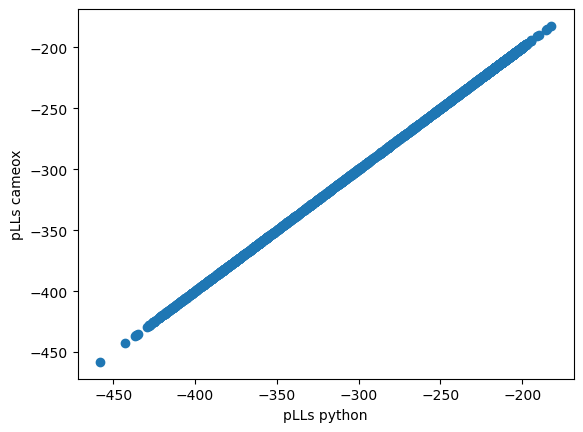

In [35]:
fig, ax = plt.subplots()
ax.scatter(plls_hunter, -aroB_pll_cameox)
ax.set(xlabel="pLLs python", ylabel="pLLs cameox")